# <span style="color:#cc6699"> Fashion item recognition</span>

#### Problem

Given an image of a fashion item, build a deep learning model that recognizes the fashion item. 
You must use at least 2 different architectures, one with MLPs and one with CNNs.
Use the Fashion-MNIST dataset to train and evaluate your models. 
More information about the task and the dataset can be found 
at https://research.zalando.com/welcome/mission/research-projects/fashion-mnist/

#### MLPs and CNN for image classification

* Our application will be on the classification of the [fashion MNIST](https://github.com/zalandoresearch/fashion-mnist) dataset.

* This contains 70K grayscale images in 10 categories, 60K for training and 10K for test.

* The images show individual articles of clothing at low resolution (28x28 pixels)

# Libraries

In [1]:
!pip install -q -U keras-tuner

     |████████████████████████████████| 71kB 7.7MB/s 


In [2]:
import tensorflow as tf
from tensorflow import keras
import random, os
import numpy as np
from numpy import dstack

import seaborn as sns

import matplotlib.pyplot as plt

from sklearn.metrics import *
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report

import seaborn as sn

import pandas as pd

from keras.callbacks import EarlyStopping

from keras.models import Sequential
from keras.models import load_model

from keras.layers import Dense, Dropout, Flatten, BatchNormalization
from keras.layers import Embedding, GlobalMaxPooling2D, Conv2D, MaxPooling2D

from keras.optimizers import Adam
from keras.optimizers import SGD

from keras.layers.core import Activation
# from keras.layers.normalization import BatchNormalization

from keras.preprocessing.image import ImageDataGenerator # for data augmentetion

import kerastuner as kt

from kerastuner.tuners import BayesianOptimization

# control the random number generators for reproducibility
np.random.seed(42)
tf.compat.v1.set_random_seed(42)
random.seed(42)
os.environ['PYTHONHASHSEED'] = '0'
os.environ['CUDA_VISIBLE_DEVICES'] = ''

# Load Dataset

In [3]:
fashion_mnist = keras.datasets.fashion_mnist

(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

4423680/4422102 [==============================] - 0s 0us/step


Categories from: https://machinelearningmastery.com/how-to-develop-a-cnn-from-scratch-for-fashion-mnist-clothing-classification/

In [4]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

In [5]:
df_cl = pd.DataFrame(class_names)
df_cl

,0
0,T-shirt/top
1,Trouser
2,Pullover
3,Dress
4,Coat
5,Sandal
6,Shirt
7,Sneaker
8,Bag
9,Ankle boot


In [6]:
N_CLASSES = 10

In [7]:
x_train.shape

(60000, 28, 28)

In [8]:
len(y_train)

60000

In [9]:
x_train, x_dev, y_train, y_dev = train_test_split(x_train, y_train, 
                                                  test_size=0.1,
#                                                   stratify=y_train,
                                                  random_state=42)

In [10]:
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, 
                                                      test_size=0.1,
#                                                       stratify=y_train,
                                                      random_state=42)

In [11]:
x_train.shape

(48600, 28, 28)

In [12]:
y_train.shape

(48600,)

In [13]:
x_valid.shape

(5400, 28, 28)

In [14]:
y_valid.shape

(5400,)

In [15]:
x_dev.shape

(6000, 28, 28)

In [16]:
x_test.shape

(10000, 28, 28)

In [17]:
image_size = int(x_test.shape[1])
print("Image size: " + str(image_size)+ 'x' +str(image_size))

Image size: 28x28


# Data exploratory analysis

In [19]:
def print_img_with_colorbar(image):   
    fig = plt.figure()
    plt.imshow(image, cmap = plt.cm.binary)
    plt.colorbar()

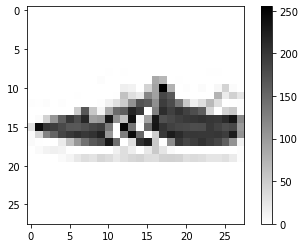

In [20]:
print_img_with_colorbar(x_train[0])

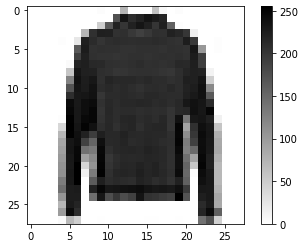

In [21]:
print_img_with_colorbar(x_train[1])

In [22]:
def print_range_images(images, images_label, class_names):
    '''
    print the first 25 images with their labels
    
    images: a array of images
    images_label: a array with the label of each image
    class_names: a list with the labels name of each class
    '''
    plt.figure(figsize=(10,10))
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i], cmap=plt.cm.binary)
        plt.xlabel(class_names[images_label[i]])

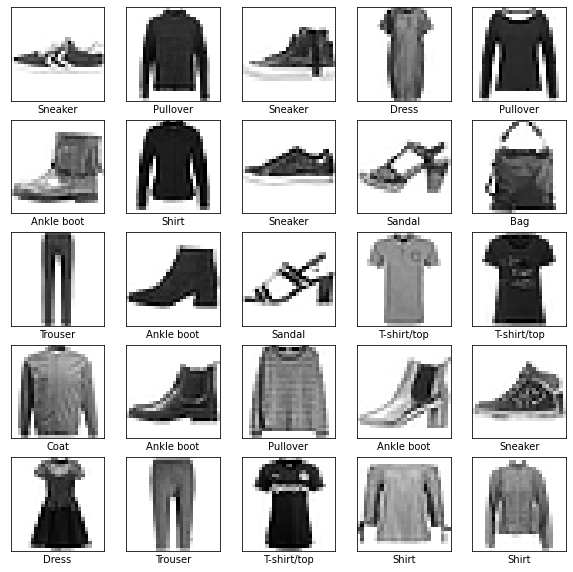

In [23]:
print_range_images(x_train, y_train, class_names)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


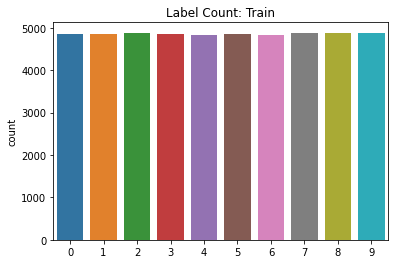

In [24]:
ax = sns.countplot(y_train)
_ = ax.set_title('Label Count: Train')

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


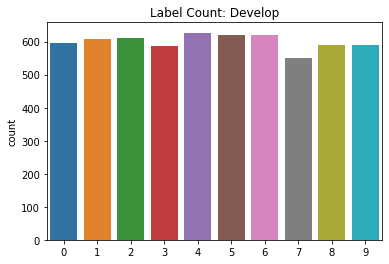

In [25]:
ax = sns.countplot(y_dev)
_ = ax.set_title('Label Count: Develop')

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


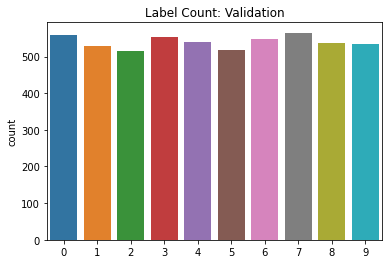

In [26]:
ax = sns.countplot(y_valid)
_ = ax.set_title('Label Count: Validation')

We have created relatively balance datasets (validation and develop) and include all the categories

# Preprocessing

### Rescale image

Normalize pixel values to a range between zero and one

In [27]:
def getRange(val_list):
    min_val = np.amin(val_list)
    max_val = np.amax(val_list)

    return (min_val, max_val)

In [28]:
getRange(x_train)

(0, 255)

The pixel values are integers with values between 0 and 255.

Neural networks process inputs using small weight values, and inputs with large integer values can disrupt or slow down the learning process. As such it is good practice to normalize the pixel values so that each pixel value has a value between 0 and 1.

In [29]:
x_train = x_train / 255.0
x_test = x_test / 255.0
x_valid = x_valid / 255.0
x_dev = x_dev/ 255.0

In [30]:
getRange(x_train)

(0.0, 1.0)

# MLP



## Build Model



* First layer: flatten the input, from 28x28 arrays to 1D arrays of 784 pixels.

* Last layer: dense, with 10 output neurons and softmax to yield the probabilities of an item belonging to each class.

* The hyperparameter search have the follow results:

The optimal number of units in the first densely-connected layer is 384

The optimal number of units in the second densely-connected layer is 256

The optimal number of dropout in the first densely-connected layer is 0.4

The optimal activation function for all layers is relu

The optimal learning rate for the optimizer is 0.0001

In [31]:
mlp_model = Sequential()
mlp_model.add(Flatten(input_shape=(28, 28)))
mlp_model.add(Dense(units=384, activation='relu'))
mlp_model.add(Dropout(0.4))
mlp_model.add(Dense(units=256, activation='relu'))
mlp_model.add(BatchNormalization())
mlp_model.add(Dense(N_CLASSES, activation='softmax'))

In [35]:
# from scratch best
# mlp_model = Sequential()
# mlp_model.add(Flatten(input_shape=(28, 28)))
# mlp_model.add(Dense(128, activation='relu'))
# mlp_model.add(Dense(100, activation='tanh',kernel_initializer = 'he_normal'))
# mlp_model.add(Dropout(0.4))
# # mlp_model.add(GaussianNoise(0.01))
# mlp_model.add(Dense(N_CLASSES, activation='softmax'))

In [32]:
mlp_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 384)               301440    
_________________________________________________________________
dropout (Dropout)            (None, 384)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               98560     
_________________________________________________________________
batch_normalization (BatchNo (None, 256)               1024      
_________________________________________________________________
dense_2 (Dense)              (None, 10)                2570      
Total params: 403,594
Trainable params: 403,082
Non-trainable params: 512
________________________________________________

In [33]:
mlp_model.count_params()

403594

## Compile model





**Loss**
* We will use categorical cross entropy for our loss function:

$$H=-\sum _{x}y(x)\,\log_2 p(x)$$

Where $p(x)$ is the network output probability distribution (the output of the 10 neurons) and $y(x)$ is the correct gold distribution for our input $x$ (the 10 labels).

* But each image ($x$) can only belong to a single class. It can be any of many, but a shirt will not be a shirt **and** boots at the same time.

This is a multi-class but not a multi-label problem, so $y$ is more like a one-hot embedding and our entropy becomes:

$$ H = -\log_2 p(x) $$

        "The network will try to learn to yield a high probability for the correct label" 
        
We have a multiclass problem, so we are using categorical cross entropy.

**Optimizer**

We'll use the Adam optimizer (Adam is short for Adaptive Moment Estimation).

(an improvement of the standard Stochastic Gradient Descent algorithm)

Description:

Adam can be looked at as a combination of RMSprop and Stochastic Gradient Descent with momentum. It uses the squared gradients to scale the learning rate like RMSprop and it takes advantage of momentum by using moving average of the gradient instead of gradient itself like SGD with momentum. 

**Evaluation metric**

We use the accuracy as our evaluation metric here. 

In [34]:
mlp_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.0001), 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

## Training phase

In [36]:
early_stop = EarlyStopping(monitor="val_loss",
                           mode="min", 
                           patience=10, 
                           restore_best_weights=True)

mlp_history = mlp_model.fit(x_train, y_train, 
                    epochs=1000, 
                    batch_size=32, 
                    validation_data=(x_valid, y_valid),
                    callbacks=[early_stop])

Epoch 1/1000
1519/1519 [==============================] - 9s 5ms/step - loss: 0.9629 - accuracy: 0.6711 - val_loss: 0.4467 - val_accuracy: 0.8439
Epoch 2/1000
1519/1519 [==============================] - 7s 5ms/step - loss: 0.4938 - accuracy: 0.8245 - val_loss: 0.3970 - val_accuracy: 0.8581
Epoch 3/1000
1519/1519 [==============================] - 7s 5ms/step - loss: 0.4429 - accuracy: 0.8410 - val_loss: 0.3656 - val_accuracy: 0.8654
Epoch 4/1000
1519/1519 [==============================] - 7s 5ms/step - loss: 0.4039 - accuracy: 0.8544 - val_loss: 0.3477 - val_accuracy: 0.8731
Epoch 5/1000
1519/1519 [==============================] - 7s 5ms/step - loss: 0.3890 - accuracy: 0.8584 - val_loss: 0.3549 - val_accuracy: 0.8763
Epoch 6/1000
1519/1519 [==============================] - 7s 5ms/step - loss: 0.3652 - accuracy: 0.8698 - val_loss: 0.3451 - val_accuracy: 0.8780
Epoch 7/1000
1519/1519 [==============================] - 7s 5ms/step - loss: 0.3483 - accuracy: 0.8727 - val_loss: 0.3303 -

In [37]:
# save model
filename = 'models/model_1.h5'
mlp_model.save(filename)
print('>Saved %s' % filename)

>Saved models/model_1.h5


In [38]:
# plot diagnostic learning curves
def summarize_diagnostics(history):
    # plot loss
    plt.figure()
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()
    
    # plot accuracy
    plt.figure()
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper right')
    plt.show()

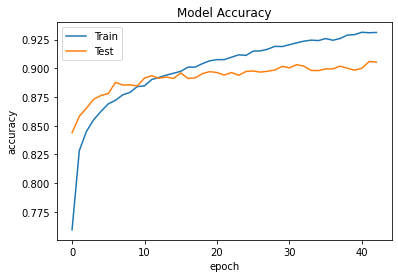

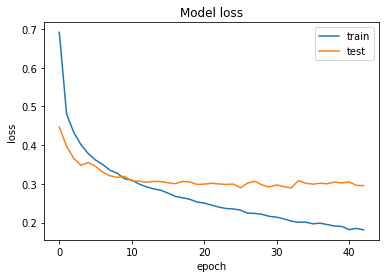

In [39]:
summarize_diagnostics(mlp_history)

## Predict phase

In [40]:
mlp_pred_distribution = mlp_model.predict(x_test)

In [41]:
mlp_pred_distribution.shape

(10000, 10)

We have one probability per class:

(probability distribution for the first example)

In [42]:
img = list(mlp_pred_distribution[0])
for i in range(len(img)):
    print(str(class_names[i])+': ' + f'{img[i]:f}')

T-shirt/top: 0.000000
Trouser: 0.000000
Pullover: 0.000000
Dress: 0.000001
Coat: 0.000000
Sandal: 0.000066
Shirt: 0.000001
Sneaker: 0.000297
Bag: 0.000000
Ankle boot: 0.999633


We use the highest probability:

In [43]:
mlp_pred_labels = [np.argmax(p) for p in mlp_pred_distribution]

## Evaluation phase

In [44]:
mlp_acc = accuracy_score(y_test, mlp_pred_labels)
mlp_acc

0.895

In [45]:
score = mlp_model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.3032819628715515
Test accuracy: 0.8949999809265137


## Error Analysis

In [46]:
misclassified_indices = np.argwhere(y_test != mlp_pred_labels)
print('Number of misclassified:', len(misclassified_indices))

Number of misclassified: 1050


In [47]:
def plot_image(prob, pred_label, true_label, img):
    '''
    prob: probability the image to be the category that we classified
    pred_label : label that predict 
    true_label : true label of image
    img: image pixels
    '''
#     print(prob)
#     print(pred_label) 
#     print(true_label) 
#     print(img) 
    
    # If the prediction is correct, the legend will be green, 
    # otherwise, red.
    if pred_label == true_label:
        color = '#014421' 
    else: 
        color = 'r'
    
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(img, cmap=plt.cm.binary)
    plt.xlabel("{} {:2.0f}% ({})".format(class_names[pred_label],
                                         10*prob,
                                         class_names[true_label]),
                                         color=color)

We visualize the test images:

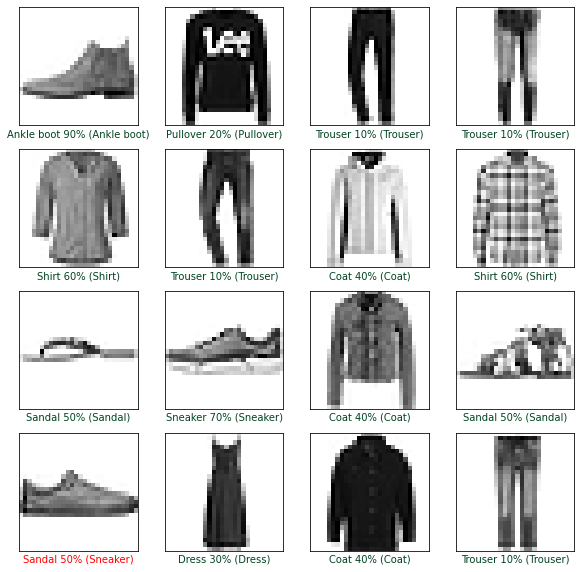

In [48]:
num_rows = 4
num_cols = 4
num_images = num_rows * num_cols

plt.figure(figsize=(10,10))
for i in range(num_images):
    plt.subplot(num_rows, num_cols, i+1)
    plot_image(np.argmax(mlp_pred_distribution[i]),
               mlp_pred_labels[i], 
               y_test[i], 
               x_test[i])

We visualize the misclassified test images:

In [49]:
misclassified_indices

array([[  12],
       [  17],
       [  23],
       ...,
       [9972],
       [9977],
       [9989]])

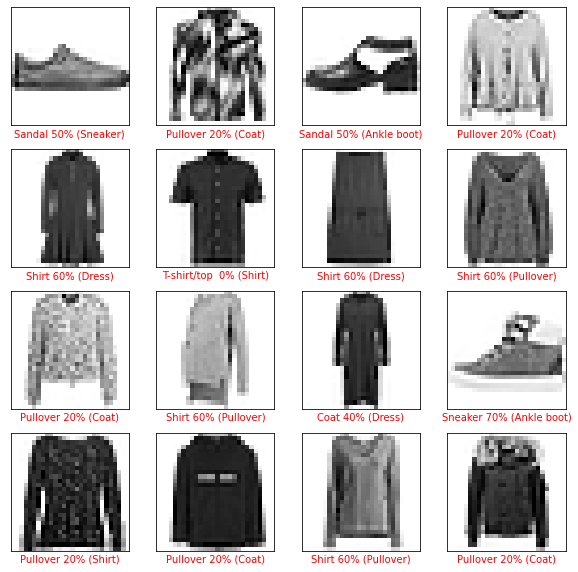

In [50]:
num_rows = 4
num_cols = 4
num_images = num_rows * num_cols

plt.figure(figsize=(10,10))
count = 1
for mis in misclassified_indices:
    i = mis[0]
    plt.subplot(num_rows, num_cols, count)
    plot_image(np.argmax(mlp_pred_distribution[i]),
               mlp_pred_labels[i], 
               y_test[i], 
               x_test[i])
    count+=1
    if count==num_images+1:
        break;

In [51]:
#https://github.com/giorgosfatouros/Deep-Learning-model-for-Fashion-item-recognition/blob/master/deep_learning_model.ipynb
def plot_image(i, predictions, true_labels, img):
    predictions_array, true_label, img = predictions[i], true_labels[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    
    plt.imshow(img.reshape(28,28), cmap=plt.cm.binary)
    
    predicted_label = np.argmax(predictions_array)
    
    if predicted_label == true_label:
        color = 'green'
    else:
        color = 'red'
  
    plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                         100*np.max(predictions_array),
                                         class_names[true_label]),
                                         color=color)
    
def plot_value_array(i, predictions, true_labels, show_xticks=False):
    predictions_array, true_label = predictions[i], true_labels[i]
    plt.grid(False)
    plt.xticks([])
    if show_xticks:
        plt.xticks(range(10), class_names, rotation='vertical')
    else:
        plt.xticks([])
    plt.yticks([])
    thisplot = plt.bar(range(10), predictions_array, color="#777777")
    plt.ylim([0, 1]) 
    predicted_label = np.argmax(predictions_array)
 
    thisplot[predicted_label].set_color('red')
    thisplot[true_label].set_color('green')

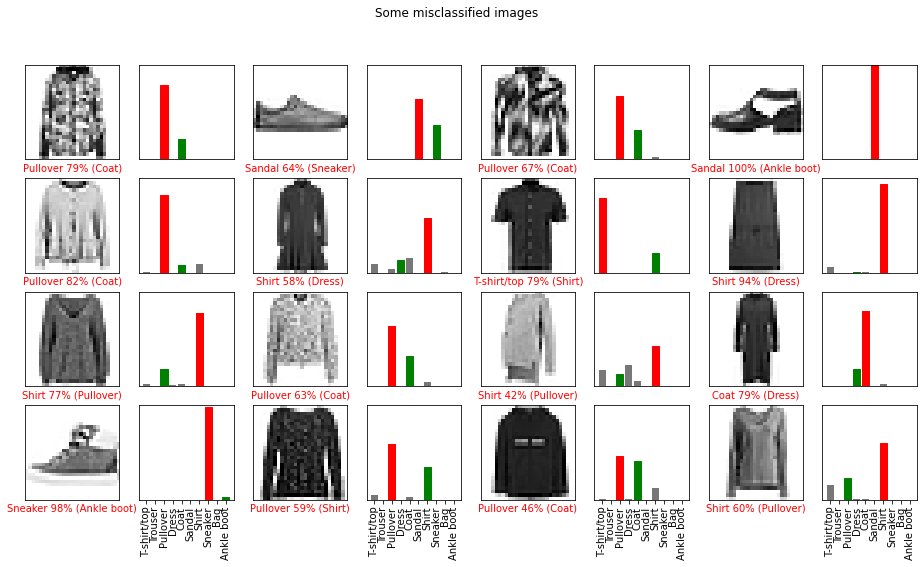

In [52]:
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
show_x_ticks = False
plt.title('Some images with their distribution/probability of each class')

for i in range(num_images):
    if i >= num_images - num_cols:
        show_x_ticks = True
    plt.subplot(num_rows, 2*num_cols, 2*i+1)
    plot_image(misclassified_indices[i-1][0], mlp_pred_distribution , y_test, x_test)
    plt.subplot(num_rows, 2 * num_cols, 2*i+2)
    plot_value_array(misclassified_indices[i-1][0], mlp_pred_distribution , y_test, show_x_ticks)

plt.suptitle('Some misclassified images')
plt.show;

## Appendix for MLP

### MLP Parameter tuning



**Hyperband** is an optimized variation of random search which uses early-stopping to speed up the process. The underlying principle of the procedure exploits the idea that if a hyperparameter configuration is expected to be the best after a considerable number of iterations, it is more likely to perform after a small number of iterations. The main idea is to fit many models for a small number of epochs and only to continue training for the models achieving the highest accuracy on the validation set. (https://www.marktechpost.com/2021/03/20/optimizing-hyperparameters-using-the-keras-tuner-framework/)

In [ ]:
def model_builder(hp):
    """######################################################################### """
    # Tune the activation function in the first and second Dense layer
    # Choose an optimal value from 'relu', 
    hp_act = hp.Choice('activation', 
                       values=(
                           'relu', 
                           'tanh', 
                           'selu',
                               ),
                       default = 'relu',
                       )
    # Tune the number of units in the first and second Dense layer
    # Choose an optimal value between 32-512
    hp_units_1 = hp.Int('units_1', 
                        min_value=32, 
                        max_value=512, 
                        step=32)
    
    hp_units_2 = hp.Int('units_2', 
                        min_value=32, 
                        max_value=512, 
                        step=32)
    # Tune the learning rate for the optimizer
    # Choose an optimal value from 0.01, 0.001, or 0.0001
    hp_learning_rate = hp.Choice('learning_rate', values=(1e-2, 1e-3, 1e-4))
    # Tune the dropout
    # Choose an optimal value from 0 to 0.6
    hp_dropout = hp.Float('dropout',
                        min_value = 0,
                        max_value = .6,
                        step = .2,
                        default = .4)
    """######################################################################### """

    mlp_model = Sequential()
    mlp_model.add(Flatten(input_shape=(28, 28)))
    mlp_model.add(Dense(units=hp_units_1, activation=hp_act))
    mlp_model.add(Dropout(hp_dropout))
    mlp_model.add(Dense(units=hp_units_2, activation=hp_act))
    mlp_model.add(BatchNormalization())
    mlp_model.add(Dense(N_CLASSES, activation='softmax'))

    mlp_model.compile(optimizer=Adam(learning_rate=hp_learning_rate),
                loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])

    return mlp_model

tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=10,
                     factor=3,
                     directory='my_dir_mlp',
                     project_name='intro_to_kt')

early_stop = EarlyStopping(monitor="val_loss",
                           mode="min", 
                           patience=10, 
                           restore_best_weights=True)

tuner.search(x_dev, y_dev,  
             epochs=100, 
             validation_data=(x_valid, y_valid), 
             callbacks=[early_stop])

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete:
The optimal number of units in the first densely-connected layer is {best_hps.get('units_1')}
The optimal number of units in the second densely-connected layer is {best_hps.get('units_2')}
The optimal number of dropout in the first densely-connected layer is {best_hps.get('dropout')}
The optimal activation function for all layers is {best_hps.get('activation')}
The optimal learning rate for the optimizer is {best_hps.get('learning_rate')}
""")



Trial 30 Complete [00h 00m 12s]
val_accuracy: 0.8396296501159668

Best val_accuracy So Far: 0.8450000286102295
Total elapsed time: 00h 02m 20s
INFO:tensorflow:Oracle triggered exit

The hyperparameter search is complete:
The optimal number of units in the first densely-connected layer is 384
The optimal number of units in the second densely-connected layer is 256
The optimal number of dropout in the first densely-connected layer is 0.4
The optimal activation function for all layers is relu
The optimal learning rate for the optimizer is 0.0001



In [ ]:
# Build the model with the optimal hyperparameters and train it on the data for 100 epochs
model = tuner.hypermodel.build(best_hps)
history = model.fit(x_train, y_train,  
             epochs=100, 
             validation_data=(x_valid, y_valid), 
             callbacks=[early_stop])

# val_acc_per_epoch = history.history['val_accuracy']
# best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
# print('Best epoch: %d' % (best_epoch,))

# hypermodel = tuner.hypermodel.build(best_hps)

# # Retrain the model with the best epoch
# hypermodel.fit(x_train, y_train, epochs=best_epoch, validation_split=(x_valid, y_valid))

eval_result = model.evaluate(x_test, y_test)
print("[test loss, test accuracy]:", eval_result)

Epoch 1/100
1519/1519 [==============================] - 7s 4ms/step - loss: 1.0039 - accuracy: 0.6589 - val_loss: 0.4277 - val_accuracy: 0.8470
Epoch 2/100
1519/1519 [==============================] - 6s 4ms/step - loss: 0.4930 - accuracy: 0.8242 - val_loss: 0.3927 - val_accuracy: 0.8585
Epoch 3/100
1519/1519 [==============================] - 6s 4ms/step - loss: 0.4465 - accuracy: 0.8411 - val_loss: 0.3711 - val_accuracy: 0.8657
Epoch 4/100
1519/1519 [==============================] - 6s 4ms/step - loss: 0.4052 - accuracy: 0.8521 - val_loss: 0.3437 - val_accuracy: 0.8781
Epoch 5/100
1519/1519 [==============================] - 6s 4ms/step - loss: 0.3914 - accuracy: 0.8585 - val_loss: 0.3406 - val_accuracy: 0.8748
Epoch 6/100
1519/1519 [==============================] - 6s 4ms/step - loss: 0.3698 - accuracy: 0.8653 - val_loss: 0.3387 - val_accuracy: 0.8763
Epoch 7/100
1519/1519 [==============================] - 6s 4ms/step - loss: 0.3525 - accuracy: 0.8739 - val_loss: 0.3222 - val_ac

### MPL with Data Augmentation

**Data augmentation** is often used in order to improve generalisation properties. Typically, horizontal ﬂipping,zooming shifts are used. However, in this case data augmentation did not improved the classifier's results. Bellow are the the data augmentation settings that tried out.

In [59]:
# inspired from
#https://github.com/giorgosfatouros/Deep-Learning-model-for-Fashion-item-recognition
#https://github.com/roatienza/Deep-Learning-Experiments/blob/master/keras/regularization/mlp-mnist-data_augment.py

image_generator = ImageDataGenerator(
      featurewise_center=True,
      featurewise_std_normalization=True,
#       rotation_range=0,
      zoom_range = 0.1, 
      width_shift_range=0.05,
      height_shift_range=0.05,
      horizontal_flip=True,
      vertical_flip=False, 
      zca_whitening=False ###<-!!!!!!
  )

# fit data for zca whitening
X_train = x_train.reshape(x_train.shape[0], image_size, image_size, 1)
image_generator.fit(X_train, augment=True)

augment_size=5000
# get transformed images
randidx = np.random.randint(X_train.shape[0], size=augment_size)
x_augmented = X_train[randidx].copy()
y_augmented = y_train[randidx].copy()
x_augmented = image_generator.flow(x_augmented, np.zeros(augment_size),
                                     batch_size=augment_size, shuffle=True).next()[0]
# append augmented data to trainset
x_train2 = np.concatenate((X_train, x_augmented))
y_train2 = np.concatenate((y_train, y_augmented))

In [60]:
X_train.shape

(48600, 28, 28, 1)

In [61]:
x_augmented.shape

(5000, 28, 28, 1)

In [62]:
x_train2.shape

(53600, 28, 28, 1)

In [63]:
x_augmented = np.reshape(x_augmented, [-1,image_size,image_size])
x_train2 = np.reshape(x_train2, [-1,image_size,image_size])

In [64]:
x_augmented.shape

(5000, 28, 28)

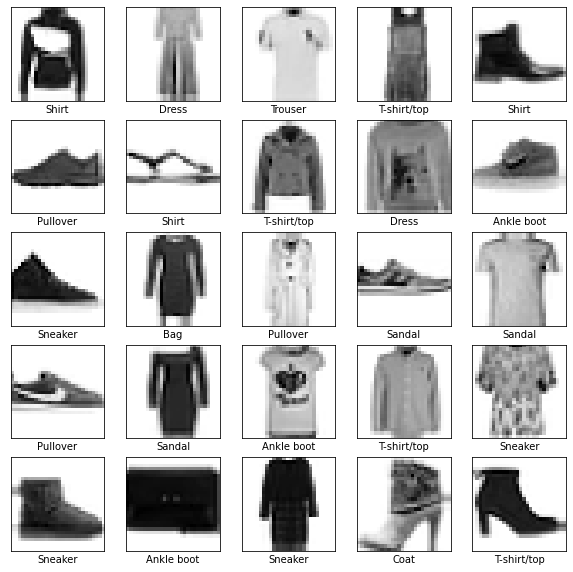

In [65]:
print_range_images(x_augmented, y_augmented, class_names)

In [66]:
#data augmentation
getRange(x_train2)

(-0.844406247138977, 2.108485221862793)

In [67]:
x_train2 = x_train2 / 255.0
getRange(x_train2)

(-0.0033113970476038317, 0.00826856949750115)

In [68]:
mlp_history2 = mlp_model.fit(x_train2, y_train2, 
                    epochs=100, 
                    batch_size=32, 
                    validation_data=(x_valid, y_valid),
                    callbacks=[early_stop])

mlp_pred_distribution2 = mlp_model.predict(x_test)
mlp_pred_labels2 = [np.argmax(p) for p in mlp_pred_distribution2]

Epoch 1/100
1675/1675 [==============================] - 9s 5ms/step - loss: 1.4413 - accuracy: 0.5586 - val_loss: 10.4096 - val_accuracy: 0.6569
Epoch 2/100
1675/1675 [==============================] - 9s 5ms/step - loss: 0.8513 - accuracy: 0.7186 - val_loss: 8.6065 - val_accuracy: 0.7533
Epoch 3/100
1675/1675 [==============================] - 9s 5ms/step - loss: 0.7263 - accuracy: 0.7509 - val_loss: 7.4634 - val_accuracy: 0.7980
Epoch 4/100
1675/1675 [==============================] - 9s 5ms/step - loss: 0.6703 - accuracy: 0.7683 - val_loss: 8.8242 - val_accuracy: 0.8126
Epoch 5/100
1675/1675 [==============================] - 9s 5ms/step - loss: 0.6347 - accuracy: 0.7785 - val_loss: 8.3535 - val_accuracy: 0.8320
Epoch 6/100
1675/1675 [==============================] - 9s 5ms/step - loss: 0.6068 - accuracy: 0.7849 - val_loss: 9.3437 - val_accuracy: 0.8409
Epoch 7/100
1675/1675 [==============================] - 9s 5ms/step - loss: 0.5903 - accuracy: 0.7904 - val_loss: 9.9204 - val_a

In [69]:
score = mlp_model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 8.305912017822266
Test accuracy: 0.7912999987602234


We observe that Data Augmantation does not improve the model, so we do NOT use. 

(original MLP: 0.895, with aug MLP: 0.791)

### MPL with Global Contrast normalization

**Global Contrast Normalization**

We try to implement global contrast normalization in python from Yoshua Bengio's Deep Learning book (section 12.2.1.1 pg. 442). From the book, to get a normalized image using global contrast normalization we use this equation:

![Title](images/Screenshot_2.png)

https://datascience.stackexchange.com/questions/15110/how-to-implement-global-contrast-normalization-in-python

In this case Global Contrast Normalization did not improved the classifier's results. Bellow are the the Global Contrast Normalization function that tried out.

In [70]:
# https://stackoverflow.com/questions/32341827/global-contrast-normalization-giving-exception-on-python
def global_contrast_normalize(X, scale=1., subtract_mean=True, use_std=False, sqrt_bias=0., min_divisor=1e-8):
    """
    Global contrast normalizes by (optionally) subtracting the mean
    across features and then normalizes by either the vector norm
    or the standard deviation (across features, for each example).
    Parameters
    ----------
    X : ndarray, 2-dimensional
        Design matrix with examples indexed on the first axis and \
        features indexed on the second.
    scale : float, optional
        Multiply features by this const.
    subtract_mean : bool, optional
        Remove the mean across features/pixels before normalizing. \
        Defaults to `True`.
    use_std : bool, optional
        Normalize by the per-example standard deviation across features \
        instead of the vector norm. Defaults to `False`.
    sqrt_bias : float, optional
        Fudge factor added inside the square root. Defaults to 0.
    min_divisor : float, optional
        If the divisor for an example is less than this value, \
        do not apply it. Defaults to `1e-8`.
    Returns
    -------
    Xp : ndarray, 2-dimensional
        The contrast-normalized features.
    Notes
    -----
    `sqrt_bias` = 10 and `use_std = True` (and defaults for all other
    parameters) corresponds to the preprocessing used in [1].
    References
    ----------
    .. [1] A. Coates, H. Lee and A. Ng. "An Analysis of Single-Layer
       Networks in Unsupervised Feature Learning". AISTATS 14, 2011.
       http://www.stanford.edu/~acoates/papers/coatesleeng_aistats_2011.pdf
    """
    assert X.ndim == 2, "X.ndim must be 2"
    scale = float(scale)
    assert scale >= min_divisor

    # Note: this is per-example mean across pixels, not the
    # per-pixel mean across examples. So it is perfectly fine
    # to subtract this without worrying about whether the current
    # object is the train, valid, or test set.
    mean = X.mean(axis=1)
    if subtract_mean:
        X = X - mean[:, np.newaxis]  # Makes a copy.
    else:
        X = X.copy()

    if use_std:
        # ddof=1 simulates MATLAB's var() behaviour, which is what Adam
        # Coates' code does.
        ddof = 1

        # If we don't do this, X.var will return nan.
        if X.shape[1] == 1:
            ddof = 0

        normalizers = np.sqrt(sqrt_bias + X.var(axis=1, ddof=ddof)) / scale
    else:
        normalizers = np.sqrt(sqrt_bias + (X ** 2).sum(axis=1)) / scale

    # Don't normalize by anything too small.
    normalizers[normalizers < min_divisor] = 1.

    X /= normalizers[:, np.newaxis]  # Does not make a copy.
    return X


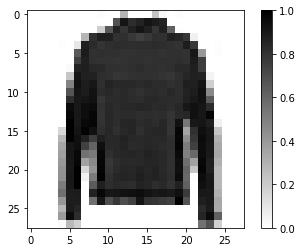

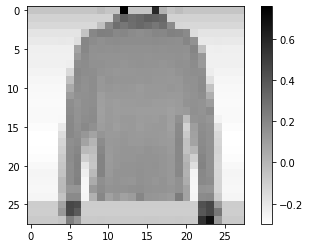

In [71]:
print_img_with_colorbar(x_train[1])
X_new = global_contrast_normalize(x_train[1])
print_img_with_colorbar(X_new)

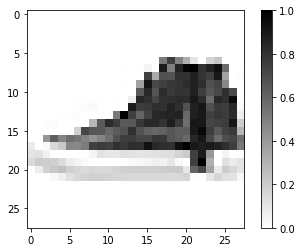

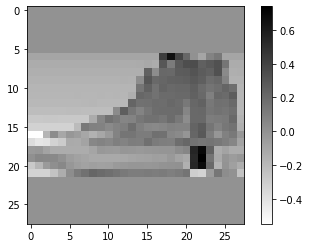

In [72]:
print_img_with_colorbar(x_train[2])
X_new = global_contrast_normalize(x_train[2])
print_img_with_colorbar(X_new)

In [73]:
getRange(X_new)

(-0.5478338850276339, 0.7387207095152117)

In [74]:
from tqdm import tqdm
x_train3 = np.array([global_contrast_normalize(image) for image in tqdm(x_train)])

100%|██████████| 48600/48600 [00:01<00:00, 31298.07it/s]


In [75]:
mlp_history3 = mlp_model.fit(x_train3, y_train, 
                    epochs=100, 
                    batch_size=32, 
                    validation_data=(x_valid, y_valid),
                    callbacks=[early_stop])

mlp_pred_distribution3 = mlp_model.predict(x_test)
mlp_pred_label3 = [np.argmax(p) for p in mlp_pred_distribution3]

Epoch 1/100
1519/1519 [==============================] - 7s 5ms/step - loss: 0.3327 - accuracy: 0.8823 - val_loss: 2.8590 - val_accuracy: 0.7256
Epoch 2/100
1519/1519 [==============================] - 7s 5ms/step - loss: 0.2506 - accuracy: 0.9059 - val_loss: 3.7827 - val_accuracy: 0.6726
Epoch 3/100
1519/1519 [==============================] - 7s 5ms/step - loss: 0.2233 - accuracy: 0.9174 - val_loss: 4.0489 - val_accuracy: 0.6652
Epoch 4/100
1519/1519 [==============================] - 7s 5ms/step - loss: 0.2076 - accuracy: 0.9214 - val_loss: 4.8207 - val_accuracy: 0.6400
Epoch 5/100
1519/1519 [==============================] - 7s 5ms/step - loss: 0.1956 - accuracy: 0.9269 - val_loss: 4.9876 - val_accuracy: 0.6374
Epoch 6/100
1519/1519 [==============================] - 7s 5ms/step - loss: 0.1917 - accuracy: 0.9280 - val_loss: 5.5523 - val_accuracy: 0.6207
Epoch 7/100
1519/1519 [==============================] - 8s 5ms/step - loss: 0.1819 - accuracy: 0.9315 - val_loss: 5.4284 - val_ac

In [76]:
score = mlp_model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 3.0458383560180664
Test accuracy: 0.7146000266075134


We observe that Global Contrast normalization does not improve the model, so we do NOT use. 

(original MlP: 0.895, with contrast MLP: 0.714)

---

# CNN



## Build Model



* First layer: a single convolutional layer with a small filter size (3,3) and a modest number of filters (32) 

* Second layer: max pooling layer

* Third layer: flatten layer  filter maps can then be flattened to provide features to the classifier

* Fourth layer: fully/densely-connected with 100 neurons, and ReLU for activation.

* Fifth layer: dense, with 10 output neurons and softwax to yield the probabilities of an item belonging to each class.

https://machinelearningmastery.com/how-to-develop-a-cnn-from-scratch-for-fashion-mnist-clothing-classification/

With Conv1D, one dimension only is used, so the convolution operates on the first axis (size 28)(like the text classif.).

With Conv2D, two dimensions are used, so the convolution operates on the two axis defining the data (size (28,28))(like the image classif.). 

So we use Conv2D and MaxPooling2D for the same reason

In [77]:
FILTERS = 32
KERNEL = (3, 3)

cnn_model = Sequential()
cnn_model.add(Conv2D(FILTERS, KERNEL, 
                 activation='relu', 
                 kernel_initializer='he_uniform',
                 input_shape=(28, 28, 1)))
cnn_model.add(MaxPooling2D(pool_size=(2, 2),
                           strides=None, 
                           padding="valid"))
cnn_model.add(Flatten())
cnn_model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
cnn_model.add(Dense(N_CLASSES, activation='softmax'))

In [78]:
cnn_model.count_params()

542230

In [ ]:
# # compile model
# opt = SGD(lr=0.01, momentum=0.9)
# cnn_model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [79]:
cnn_model.compile(optimizer=tf.keras.optimizers.Adam(), 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [80]:
# reshape dataset to have a single channel
trainX = x_train.reshape((x_train.shape[0], 28, 28, 1))
validX = x_valid.reshape((x_valid.shape[0], 28, 28, 1))
testX = x_test.reshape((x_test.shape[0], 28, 28, 1))
devX = x_dev.reshape((x_dev.shape[0], 28, 28, 1))

## Training phase

In [82]:
cnn_history = cnn_model.fit(trainX,
                    y_train,  
                    epochs=1000, 
                    batch_size=32, 
                    validation_data=(validX, y_valid),
                    callbacks=[early_stop])

Epoch 1/1000
1519/1519 [==============================] - 25s 17ms/step - loss: 0.1996 - accuracy: 0.9267 - val_loss: 0.2857 - val_accuracy: 0.9020
Epoch 2/1000
1519/1519 [==============================] - 25s 17ms/step - loss: 0.1687 - accuracy: 0.9376 - val_loss: 0.2894 - val_accuracy: 0.9041
Epoch 3/1000
1519/1519 [==============================] - 25s 17ms/step - loss: 0.1460 - accuracy: 0.9459 - val_loss: 0.2778 - val_accuracy: 0.9081
Epoch 4/1000
1519/1519 [==============================] - 25s 17ms/step - loss: 0.1218 - accuracy: 0.9549 - val_loss: 0.2959 - val_accuracy: 0.9041
Epoch 5/1000
1519/1519 [==============================] - 25s 16ms/step - loss: 0.1057 - accuracy: 0.9610 - val_loss: 0.3026 - val_accuracy: 0.9057
Epoch 6/1000
1519/1519 [==============================] - 26s 17ms/step - loss: 0.0891 - accuracy: 0.9679 - val_loss: 0.3348 - val_accuracy: 0.9120
Epoch 7/1000
1519/1519 [==============================] - 25s 17ms/step - loss: 0.0758 - accuracy: 0.9726 - val_

In [83]:
# save model
filename = 'models/model_2.h5'
cnn_model.save(filename)
print('>Saved %s' % filename)

>Saved models/model_2.h5


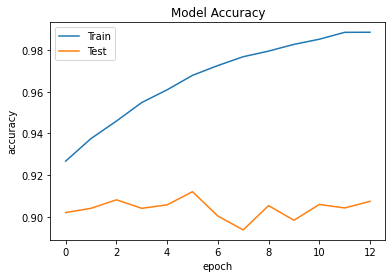

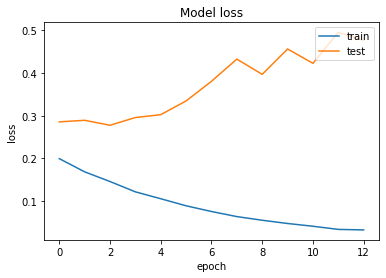

In [84]:
summarize_diagnostics(cnn_history)

## Predict phase

In [85]:
cnn_pred_distribution = cnn_model.predict(testX)

In [86]:
cnn_pred_labels = [np.argmax(p) for p in cnn_pred_distribution]

## Evaluation phase

In [87]:
cnn_acc = accuracy_score(y_test, cnn_pred_labels)
cnn_acc

0.9105

## Error Analysis

In [88]:
misclassified_indices_cnn = np.argwhere(y_test != cnn_pred_labels)
print('Number of misclassified:', len(misclassified_indices_cnn))

Number of misclassified: 895


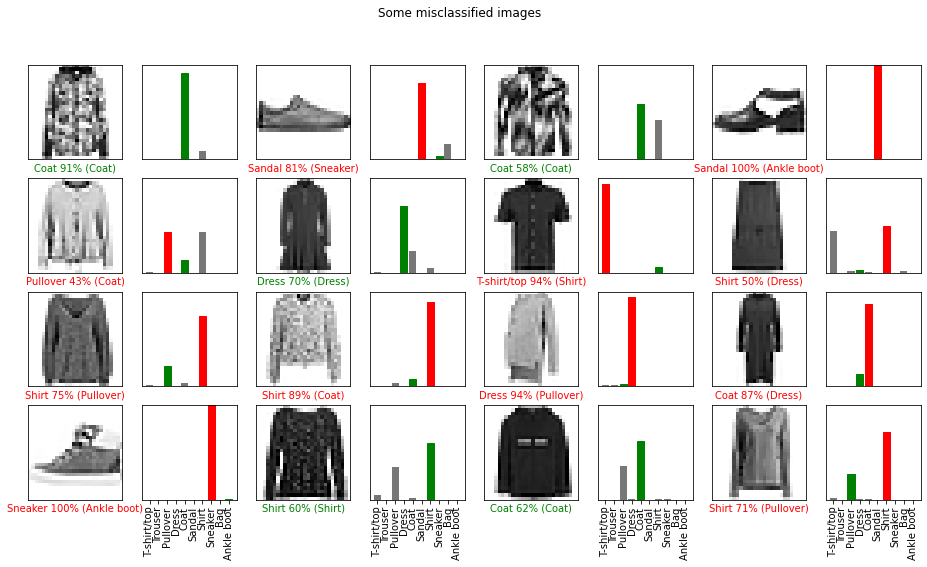

In [96]:
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
show_x_ticks = False
plt.title('Some images with their distribution/probability of each class')

for i in range(num_images):
    if i >= num_images - num_cols:
        show_x_ticks = True
    plt.subplot(num_rows, 2*num_cols, 2*i+1)
    plot_image(misclassified_indices[i-1][0], cnn_pred_distribution , y_test, x_test)
    plt.subplot(num_rows, 2 * num_cols, 2*i+2)
    plot_value_array(misclassified_indices[i-1][0], cnn_pred_distribution , y_test, show_x_ticks)

plt.suptitle('Some misclassified images')
plt.show;

## Appendix for CNN

### CNN Parameter tuning

In [ ]:
from keras.layers import GlobalAveragePooling2D

def model_builder(hp):
    """######################################################################### """
    # Tune the activation function in the first and second Dense layer
    # Choose an optimal value from 'relu', 
    hp_act = hp.Choice('activation', 
                       values=(
                           'relu', 
                           'tanh', 
                           'selu',
                               ),
                       default = 'relu',
                       )
    # Tune the number of units in the Dense layer
    # Choose an optimal value between 32-512
    hp_units = hp.Int('units', 
                        min_value=32, 
                        max_value=512, 
                        step=32)
    # Tune the learning rate for the optimizer
    # Choose an optimal value from 0.01, 0.001, or 0.0001
    hp_learning_rate = hp.Choice('learning_rate', values=(1e-2, 1e-3, 1e-4))
    # Tune the dropout
    # Choose an optimal value from 0 to 0.6
    hp_dropout_2 = hp.Float('dropout_2',
                        min_value = 0,
                        max_value = .6,
                        step = .2,
                        default = .4)
    # Tune the filters
    hp_filters_1 = hp.Choice('num_filters_1',
                        values=(16, 32, 64),
                        default=32,
                        )
    hp_filters_2 = hp.Choice('num_filters_2',
                        values=(16, 32, 64),
                        default=32,
                        )
    """######################################################################### """
    # FILTERS = 32
    KERNEL = (3, 3)

    cnn_model = Sequential()
    cnn_model.add(Conv2D( filters = hp_filters_1, 
                    kernel_size = KERNEL, 
                    activation = hp_act, 
                    kernel_initializer = 'he_uniform',
                    input_shape = (28, 28, 1)))
    # cnn_model.add(BatchNormalization())

    cnn_model.add(MaxPooling2D(pool_size=(2, 2),
                            strides=None, 
                            padding="same"))
    ##"valid" means no padding. "same" results in padding evenly to the 
    ##left/right or up/down of the input such that output has the same
    ##height/width dimension as the input.
    
    cnn_model.add(Conv2D( filters = hp_filters_2, 
                    kernel_size = KERNEL, 
                    activation = hp_act))
    cnn_model.add(GlobalAveragePooling2D())

    # cnn_model.add(MaxPooling2D(pool_size=(2, 2),
    #                            strides=(1,1)), 
    #                            padding="valid"))

    # cnn_model.add(AveragePooling2D(pool_size=(2, 2),
    #                            strides=(1,1)), 
    #                            padding="valid"))
    cnn_model.add(Flatten())
    cnn_model.add(Dense(units=hp_units, activation=hp_act))
    cnn_model.add(Dropout(hp_dropout_2))
    cnn_model.add(Dense(N_CLASSES, activation='softmax'))

    cnn_model.compile(optimizer=Adam(learning_rate=hp_learning_rate),
                loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])

    return cnn_model

tuner_cnn = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=10,
                     factor=3,
                     directory='my_dir_cnn',
                     project_name='intro_to_kt_cnn')

early_stop_2 = EarlyStopping(monitor="val_loss",
                           mode="min", 
                           patience=10, 
                           restore_best_weights=True)

tuner_cnn.search(devX,
            y_dev,  
             epochs=100, 
             validation_data=(validX, y_valid), 
             callbacks=[early_stop_2])

# Get the optimal hyperparameters
best_hps_cnn = tuner_cnn.get_best_hyperparameters(num_trials=1)[0]

INFO:tensorflow:Reloading Oracle from existing project my_dir_cnn/intro_to_kt_cnn/oracle.json


INFO:tensorflow:Reloading Oracle from existing project my_dir_cnn/intro_to_kt_cnn/oracle.json


INFO:tensorflow:Reloading Tuner from my_dir_cnn/intro_to_kt_cnn/tuner0.json


INFO:tensorflow:Reloading Tuner from my_dir_cnn/intro_to_kt_cnn/tuner0.json


INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit


In [ ]:
print(f"""
The hyperparameter search is complete:
The optimal number of filter of first Con2d is {best_hps_cnn.get('num_filters_1')}
The optimal number of filter of second Con2d is {best_hps_cnn.get('num_filters_2')}
The optimal number of units in the densely-connected layer is {best_hps_cnn.get('units')}
The optimal number of dropout in the densely-connected layer is {best_hps_cnn.get('dropout_2')}
The optimal activation function for all layers is {best_hps_cnn.get('activation')}
The optimal learning rate for the optimizer is {best_hps_cnn.get('learning_rate')}
""")


The hyperparameter search is complete:
The optimal number of filter of first Con2d is 32
The optimal number of filter of second Con2d is 64
The optimal number of units in the densely-connected layer is 160
The optimal number of dropout in the densely-connected layer is 0.4
The optimal activation function for all layers is selu
The optimal learning rate for the optimizer is 0.01



In [ ]:
# Build the model with the optimal hyperparameters and train it on the data for 100 epochs
model_cnn = tuner_cnn.hypermodel.build(best_hps_cnn)
history_cnn = model_cnn.fit(trainX, y_train,  
             epochs=100, 
             validation_data=(validX, y_valid), 
             callbacks=[early_stop])

# val_acc_per_epoch = history.history['val_accuracy']
# best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
# print('Best epoch: %d' % (best_epoch,))

# hypermodel = tuner.hypermodel.build(best_hps)

# # Retrain the model with the best epoch
# hypermodel.fit(x_train, y_train, epochs=best_epoch, validation_split=(x_valid, y_valid))

eval_result_cnn = model_cnn.evaluate(testX, y_test)
print("[test loss, test accuracy]:", eval_result_cnn)

Epoch 1/100
1519/1519 [==============================] - 32s 21ms/step - loss: 1.0883 - accuracy: 0.6175 - val_loss: 0.6473 - val_accuracy: 0.7685
Epoch 2/100
1519/1519 [==============================] - 33s 22ms/step - loss: 0.7553 - accuracy: 0.7438 - val_loss: 0.9042 - val_accuracy: 0.6896
Epoch 3/100
1519/1519 [==============================] - 34s 23ms/step - loss: 0.7613 - accuracy: 0.7525 - val_loss: 0.5928 - val_accuracy: 0.7993
Epoch 4/100
1519/1519 [==============================] - 36s 23ms/step - loss: 0.7122 - accuracy: 0.7721 - val_loss: 0.7078 - val_accuracy: 0.7891
Epoch 5/100
1519/1519 [==============================] - 36s 23ms/step - loss: 0.6903 - accuracy: 0.7839 - val_loss: 0.5965 - val_accuracy: 0.8157
Epoch 6/100
1519/1519 [==============================] - 36s 23ms/step - loss: 0.6983 - accuracy: 0.7908 - val_loss: 0.5911 - val_accuracy: 0.8228
Epoch 7/100
1519/1519 [==============================] - 36s 23ms/step - loss: 0.6870 - accuracy: 0.7943 - val_loss: 0

# Ensemble learning



From Wikipedia:

Ensemble methods use multiple learning algorithms to obtain better predictive performance than could be obtained from any of the constituent learning algorithms alone.

https://medium.com/@aytaj.aghabayli/ensembling-soft-hard-classifications-from-multiple-classifiers-using-the-neural-classifier-58a185a4e4d9

The architecture of a stacking model involves:
* Level-0 Models (Base-Models): Models fit on the training data and whose predictions are compiled.
* Level-1 Model (Meta-Model): Model that learns how to best combine the predictions of the base models.

https://machinelearningmastery.com/stacking-ensemble-for-deep-learning-neural-networks/

In [97]:
def load_all_models(n_models):
    all_models = list()
    for i in range(n_models):
        # define filename for this ensemble
        filename = 'models/model_' + str(i + 1) + '.h5'
        # load model from file
        model = load_model(filename)
        # add to list of members
        all_models.append(model)
        print('>loaded %s' % filename)
    return all_models

In [98]:
# load all models
n_members = 2
members = load_all_models(n_members)
print('Loaded %d models' % len(members))

>loaded models/model_1.h5
>loaded models/model_2.h5
Loaded 2 models


In [99]:
# create stacked model input dataset as outputs from the ensemble
def stacked_dataset(members, inputX):
    stackX = None
    
    #we need this flag because input of mlp are 3 dim vs cnn are 4 dim
    flag_model_cnn = False
    
    for model in members:
        if flag_model_cnn == False:
            # make prediction
            yhat = model.predict(inputX, verbose=0)
            flag_model_cnn = True
        elif flag_model_cnn == True:
            inputX = inputX.reshape((inputX.shape[0], 28, 28, 1))
            # make prediction
            yhat = model.predict(inputX, verbose=0)
            
        # stack predictions into [rows, members, probabilities]
        if stackX is None:
            stackX = yhat
        else:
            stackX = dstack((stackX, yhat))
            
    # flatten predictions to [rows, members x probabilities]
    stackX = stackX.reshape((stackX.shape[0], stackX.shape[1]*stackX.shape[2]))
    return stackX

In [100]:
def fit_stacked_model(members, inputX, inputy):
    # create dataset using ensemble
    stackedX = stacked_dataset(members, inputX)
    # fit standalone model
    model = LogisticRegression()
    model.fit(stackedX, inputy)
    return model

In [101]:
# fit stacked model using the ensemble
model = fit_stacked_model(members, x_test, y_test)

In [102]:
# make a prediction with the stacked model
def stacked_prediction(members, model, inputX):
    # create dataset using ensemble
    stackedX = stacked_dataset(members, inputX)
    # make a prediction
    yhat = model.predict(stackedX)
    return yhat

In [103]:
# evaluate model on test set
yhat = stacked_prediction(members, model, x_test)
acc = accuracy_score(y_test, yhat)

# Evalute All Models

In [104]:
print('MLP Accuracy: ' + str(mlp_acc))
print('CNN Accuracy: ' + str(cnn_acc))
print('Stacked Accuracy: %.4f' % acc)
print('(Stacked: MLP+CNN = logistic regression)')

MLP Accuracy: 0.895
CNN Accuracy: 0.9105
Stacked Accuracy: 0.9171
(Stacked: MLP+CNN = logistic regression)


**ROC** curve show one-vs-all classes.

In [105]:
def roc_plot(name_plot, y_test, pred_distribution, class_names):
    plt.figure()
    # roc curve for classes
    fpr = {}
    tpr = {}
    thresh ={}
    for i in range(N_CLASSES):
        fpr[i], tpr[i], thresh[i] = roc_curve(y_test, pred_distribution[:,i], pos_label=i)
        plt.plot(fpr[i], tpr[i], linestyle='--', label=str(class_names[i])+' vs Rest')
        plt.title(name_plot+': Multiclass ROC curve')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive rate')
        plt.legend(loc='best')
#         plt.savefig('Multiclass ROC',dpi=300); 
    plt.show()
    
    roc_plot_zoom(fpr, tpr,N_CLASSES)

In [106]:
def roc_plot_zoom(fpr, tpr,N_CLASSES):
    plt.figure()
    for i in range(N_CLASSES): 
        plt.plot(fpr[i], tpr[i], linestyle='--', label=str(class_names[i])+' vs Rest')
        plt.title('Multiclass ROC curve with zoom')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive rate')
        plt.legend(loc='best')
        plt.xlim(-0.005, 0.4)
        plt.ylim(0.8 , 1.005)
#         plt.savefig('Multiclass ROC zoom',dpi=300);
    plt.show()

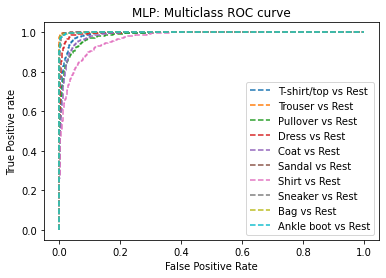

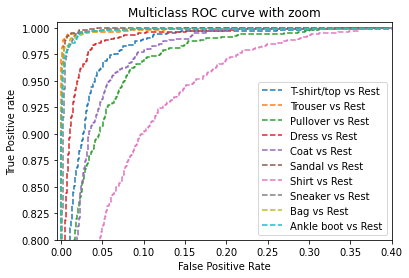

In [122]:
name_plot = 'MLP'
roc_plot(name_plot, y_test, mlp_pred_distribution, class_names)

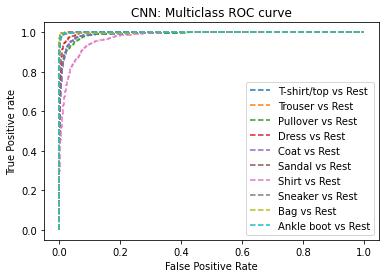

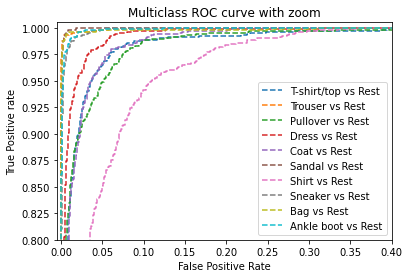

In [107]:
name_plot = 'CNN'
roc_plot(name_plot, y_test, cnn_pred_distribution, class_names)

We observe that MLP and CNN find difficult to classify the shirt correctly. Generaly, plots are very similar and it is obvious as they have similar accurancies.

**Confusion_matrix**

In [108]:
confusion_mlp = confusion_matrix(y_test, mlp_pred_labels)

print('MLP: Confusion Matrix\n')

df_cm_mlp = pd.DataFrame(confusion_mlp, index = [i for i in class_names],
                  columns = [i for i in class_names])
df_cm_mlp

MLP: Confusion Matrix



,T-shirt/top,Trouser,Pullover,Dress,Coat,Sandal,Shirt,Sneaker,Bag,Ankle boot
T-shirt/top,834,1,11,19,5,2,125,0,3,0
Trouser,3,977,0,13,3,0,3,0,1,0
Pullover,14,1,835,8,77,0,65,0,0,0
Dress,15,5,8,896,32,0,40,0,4,0
Coat,0,0,106,29,798,0,66,0,1,0
Sandal,0,0,0,0,0,966,0,22,2,10
Shirt,93,0,71,27,62,0,744,0,3,0
Sneaker,0,0,0,0,0,7,0,971,0,22
Bag,6,0,9,4,4,3,8,5,961,0
Ankle boot,0,0,0,0,0,4,1,27,0,968


In [109]:
def plot_confusion_matrix(df_cm,name_plot):    
    index = df_cm.index
    index.name = "Actual"

    columns= df_cm.columns
    columns.name = "Predict"

    plt.figure(figsize = (12,9))

    # flights.pivot("month", "year")

    # by default number in float .2 : fmt=.2g, but we want eg.789
    sn.heatmap(df_cm/np.sum(df_cm), annot=True,fmt='.1%',
               cmap=sns.cubehelix_palette(as_cmap=True))

    # fix for mpl bug that cuts off top/bottom of seaborn viz
    b, t = plt.ylim() # discover the values for bottom and top
    b += 0.5 # Add 0.5 to the bottom
    t -= 0.5 # Subtract 0.5 from the top
    plt.ylim(b, t) # update the ylim(bottom, top) values

    plt.title(name_plot+': Confusion Matrix with percentage %')

    #Rotating axis labels
    plt.xticks(
        rotation=45, 
        horizontalalignment='right',
    )

    plt.show()

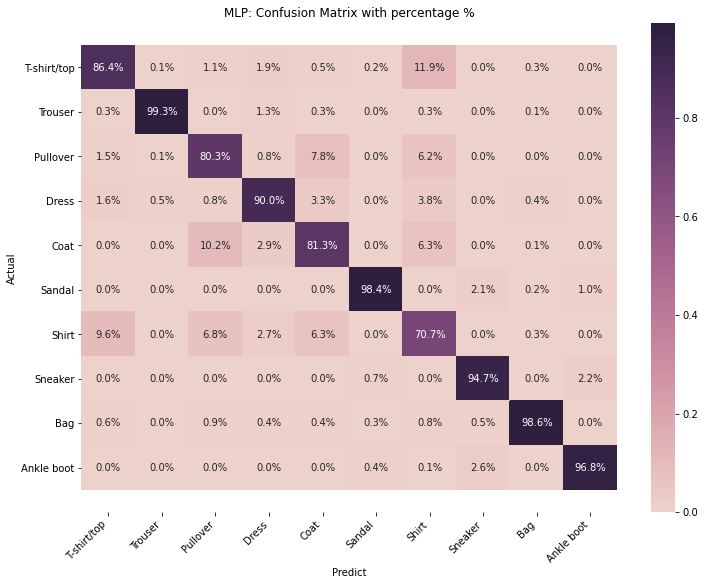

In [110]:
plot_confusion_matrix(df_cm_mlp,'MLP')

In [111]:
confusion_cnn = confusion_matrix(y_test, cnn_pred_labels)

print('MLP: Confusion Matrix\n')

df_cm_cnn = pd.DataFrame(confusion_cnn, index = [i for i in class_names],
                  columns = [i for i in class_names])
df_cm_cnn

MLP: Confusion Matrix



,T-shirt/top,Trouser,Pullover,Dress,Coat,Sandal,Shirt,Sneaker,Bag,Ankle boot
T-shirt/top,871,2,8,12,4,2,94,0,7,0
Trouser,0,991,1,4,0,0,2,0,2,0
Pullover,26,1,828,10,67,0,67,0,1,0
Dress,17,24,8,886,32,0,31,0,2,0
Coat,1,1,34,22,877,0,65,0,0,0
Sandal,0,0,0,0,0,984,0,6,0,10
Shirt,93,4,31,25,72,0,766,0,8,1
Sneaker,0,0,0,0,0,16,0,970,0,14
Bag,2,2,1,4,0,1,3,5,982,0
Ankle boot,0,0,0,0,0,3,1,46,0,950


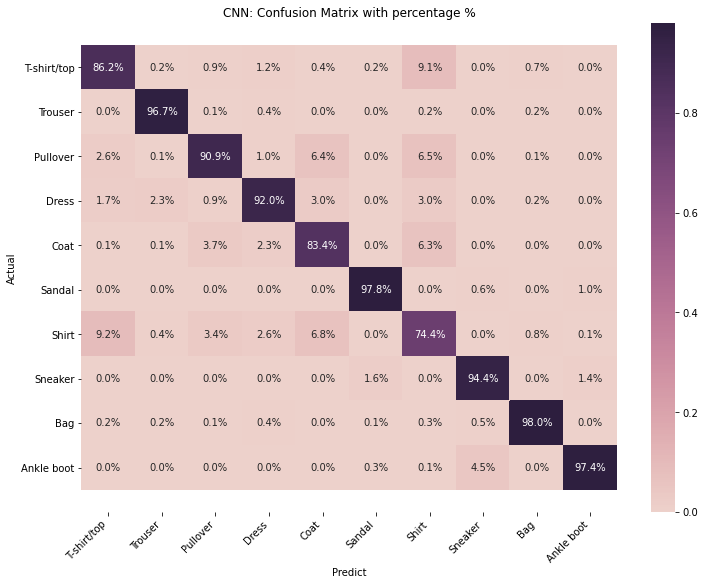

In [112]:
plot_confusion_matrix(df_cm_cnn,'CNN')

In [113]:
confusion_st = confusion_matrix(y_test, yhat)

print('MLP: Confusion Matrix\n')

df_cm_st = pd.DataFrame(confusion_st, index = [i for i in class_names],
                  columns = [i for i in class_names])
df_cm_st

MLP: Confusion Matrix



,T-shirt/top,Trouser,Pullover,Dress,Coat,Sandal,Shirt,Sneaker,Bag,Ankle boot
T-shirt/top,870,1,7,12,4,1,100,0,5,0
Trouser,0,986,0,9,0,0,4,0,1,0
Pullover,18,1,854,11,58,0,58,0,0,0
Dress,15,7,9,909,28,0,31,0,1,0
Coat,0,1,40,23,884,0,52,0,0,0
Sandal,0,0,0,0,0,986,0,6,0,8
Shirt,94,1,50,23,59,0,767,0,6,0
Sneaker,0,0,0,0,0,13,0,967,0,20
Bag,3,0,3,5,1,1,5,4,978,0
Ankle boot,0,0,0,0,0,3,1,26,0,970


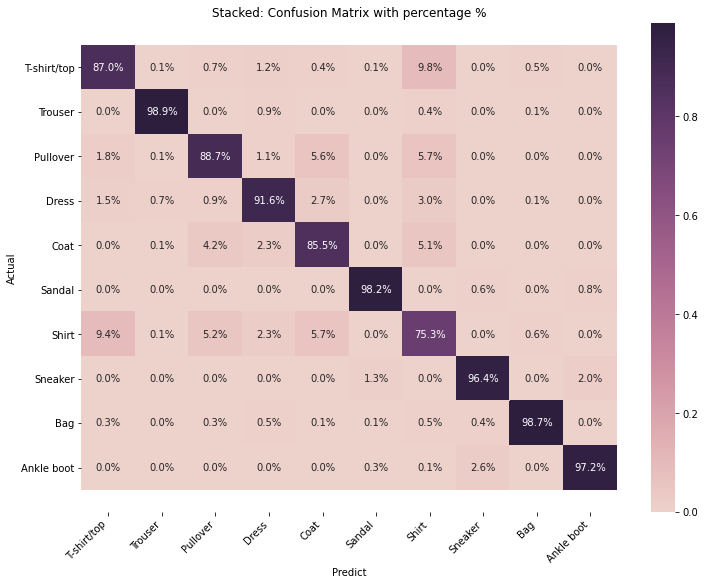

In [114]:
plot_confusion_matrix(df_cm_st,'Stacked')

In [115]:
def print_metrics(y_test, y_pred, name):
    print(name+ ' Metrics:')
    print('______________')
    
    print('\nAccuracy: {:.2f}\n'.format(accuracy_score(y_test, y_pred)))

    print('Micro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='micro')))
    print('Micro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='micro')))
    print('Micro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='micro')))

    print('Macro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='macro')))
    print('Macro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='macro')))
    print('Macro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='macro')))

    print('Weighted Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='weighted')))
    print('Weighted Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='weighted')))
    print('Weighted F1-score: {:.2f}'.format(f1_score(y_test, y_pred, average='weighted')))

In [116]:
print_metrics(y_test, mlp_pred_labels, 'MLP')

MLP Metrics:
______________

Accuracy: 0.90

Micro Precision: 0.90
Micro Recall: 0.90
Micro F1-score: 0.90

Macro Precision: 0.90
Macro Recall: 0.89
Macro F1-score: 0.90

Weighted Precision: 0.90
Weighted Recall: 0.90
Weighted F1-score: 0.90


In [117]:
print('\nClassification Report\n')
print(classification_report(y_test, mlp_pred_labels, target_names=class_names))


Classification Report

              precision    recall  f1-score   support

 T-shirt/top       0.86      0.83      0.85      1000
     Trouser       0.99      0.98      0.98      1000
    Pullover       0.80      0.83      0.82      1000
       Dress       0.90      0.90      0.90      1000
        Coat       0.81      0.80      0.81      1000
      Sandal       0.98      0.97      0.97      1000
       Shirt       0.71      0.74      0.73      1000
     Sneaker       0.95      0.97      0.96      1000
         Bag       0.99      0.96      0.97      1000
  Ankle boot       0.97      0.97      0.97      1000

    accuracy                           0.90     10000
   macro avg       0.90      0.89      0.90     10000
weighted avg       0.90      0.90      0.90     10000



In [118]:
print_metrics(y_test, cnn_pred_labels, 'CNN')

CNN Metrics:
______________

Accuracy: 0.91

Micro Precision: 0.91
Micro Recall: 0.91
Micro F1-score: 0.91

Macro Precision: 0.91
Macro Recall: 0.91
Macro F1-score: 0.91

Weighted Precision: 0.91
Weighted Recall: 0.91
Weighted F1-score: 0.91


In [119]:
print('\nClassification Report\n')
print(classification_report(y_test, cnn_pred_labels, target_names=class_names))


Classification Report

              precision    recall  f1-score   support

 T-shirt/top       0.86      0.87      0.87      1000
     Trouser       0.97      0.99      0.98      1000
    Pullover       0.91      0.83      0.87      1000
       Dress       0.92      0.89      0.90      1000
        Coat       0.83      0.88      0.85      1000
      Sandal       0.98      0.98      0.98      1000
       Shirt       0.74      0.77      0.76      1000
     Sneaker       0.94      0.97      0.96      1000
         Bag       0.98      0.98      0.98      1000
  Ankle boot       0.97      0.95      0.96      1000

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.91      0.91     10000



In [120]:
print_metrics(y_test, yhat, 'Stacked')

Stacked Metrics:
______________

Accuracy: 0.92

Micro Precision: 0.92
Micro Recall: 0.92
Micro F1-score: 0.92

Macro Precision: 0.92
Macro Recall: 0.92
Macro F1-score: 0.92

Weighted Precision: 0.92
Weighted Recall: 0.92
Weighted F1-score: 0.92


In [121]:
print('\nClassification Report\n')
print(classification_report(y_test, yhat, target_names=class_names))


Classification Report

              precision    recall  f1-score   support

 T-shirt/top       0.87      0.87      0.87      1000
     Trouser       0.99      0.99      0.99      1000
    Pullover       0.89      0.85      0.87      1000
       Dress       0.92      0.91      0.91      1000
        Coat       0.85      0.88      0.87      1000
      Sandal       0.98      0.99      0.98      1000
       Shirt       0.75      0.77      0.76      1000
     Sneaker       0.96      0.97      0.97      1000
         Bag       0.99      0.98      0.98      1000
  Ankle boot       0.97      0.97      0.97      1000

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000



---

# Appendix

## Parameter tuning

We selected **Ηyperopt** as tuner, because it is very fast due to the parallel running. For example, Grid Search (belong to Random Search) has taken much more time to complete.
(the performance of the algorithms in order to decide which method we will choose, we found it from https://gsarantitis.wordpress.com/2018/05/13/neural-network-hyper-parameter-tuning-showcasing-three-techniques/)

In [ ]:
# !pip install hyperopt

In [ ]:
from hyperopt import hp, fmin, tpe, hp, STATUS_OK, Trials, space_eval

`hyperopt` is a method of stochastic target function minimization, which uses bayesian approach for intelligent points sampling from search space. It adjusts prior distribution using history of target function evaluations, concentrating probability mass in the region where function performs better.(https://www.kaggle.com/fanvacoolt/tutorial-on-hyperopt)

In [ ]:
#https://www.kaggle.com/inspector/keras-hyperopt-example-sketch

#This is the parameter space to explore with hyperopt
space = {
    
    'choice':

    hp.choice('num_layers',
    [
                    {'layers':'two',                               
                    },
                     {'layers':'three',
                      
                      'units3': hp.choice('units3', [64]),
                      'dropout3': hp.choice('dropout3', [0,0.2])
                                
                    }
    
    ]),
    
    'units1': hp.choice('units1', [64,128]),
    'units2': hp.choice('units2', [64,100]),
                 
    'dropout1': hp.choice('dropout1', [0, 0.2, 0.4]),
    'dropout2': hp.choice('dropout2', [0, 0.2, 0.4]),
    
    'activation1': hp.choice('activation1',['relu','tanh','softmax']),
    'activation2': hp.choice('activation2',['relu','tanh','softmax']),
    'activation3': hp.choice('activation3',['relu','tanh','softmax']),
    
    'batch_size' : hp.choice('batch_size', [28, 32, 64]),

    'nb_epochs' :  100,
#     'optimizer': 'adadelta'
       
    }

In [ ]:
def create_model(params):
    
    model = Sequential()
    model.add(Flatten(input_shape=(28, 28)))
    model.add(Dense(output_dim=params['units1'])) 
    model.add(Activation(params['activation1']))
    model.add(Dropout(params['dropout1']))
    model.add(BatchNormalization())
    
    model.add(Dense(output_dim=params['units2'],kernel_initializer = 'he_normal')) 
    model.add(Activation(params['activation2']))
    model.add(Dropout(params['dropout2']))
    model.add(BatchNormalization())
    
    if params['choice']['layers']== 'three':
        model.add(Dense(output_dim=params['choice']['units3'], init = "glorot_uniform")) 
        model.add(Activation(params['activation3']))
        model.add(Dropout(params['choice']['dropout3']))
        model.add(BatchNormalization())
#         patience=25
#     else:
#         patience=15
    
    model.add(Dense(N_CLASSES, activation='softmax'))
    
    return model

In [ ]:
#Objective function that hyperopt will minimize
def objective(params):
    
    print ('Params testing: ', params)
    print ('\n ')
    
    model = create_model(params)
    
    ##
    model.compile(optimizer=tf.keras.optimizers.Adam(), 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
    ##
    #includes the call back object
    model.fit(x_train, y_train, 
                    epochs=params['nb_epochs'], 
                    batch_size=params['batch_size'], 
                    validation_data=(x_valid, y_valid),
                    callbacks=[early_stop])
    
    #predict the test set 
    pred_distribution = model.predict(x_dev)
    
    pred_labels = [np.argmax(p) for p in pred_distribution]
    
    acc = accuracy_score(y_dev, pred_labels)
    
#     predClipped = np.clip(np.round(preds.astype(int).ravel()), 1, 8) #simple rounding of predictionto int
#     score=ml_metrics.quadratic_weighted_kappa(y_test.values.ravel(),predClipped)
 
    return {'loss': acc, 'status': STATUS_OK}

https://www.kaggle.com/fanvacoolt/tutorial-on-hyperopt

**fmin** - central function of hyperopt, it performs guided search for a function minimum. It returns the point from parameters hyperspace that yielded the lowest loss. Most important arguments are:

* fn - function to minimize. Must accept a sample from parameters hyperspace and return real number (it might also return a dictionary, which has to contain two mandatory records: loss and status. Other elements you can design youself, if you want to, say, keep track of some other value during optimization. More on that later);

* space - parameters hyperspace to sample from;

* algo - algorithm which suggests new point given the points history. There are two options - tpe.suggest (guided search) and tpe.rand.suggest (essentially random search. If you want it);

* max_evals - number of points to sample;

* trials - object of class Trial to keep track of optimization history;

(Extra: 

rstate - pseudo-random generator seed, analogous to random_state from sklearn, for reproducibility;

show_progressbar - well, kind of explains itself, doesn't it?)

**Trials** - class, instances of which keep track of entire optimization process (stuff like parameters values, loss values, etc.);

In [ ]:
trials = Trials()

best = fmin(objective, space, algo=tpe.suggest, trials=trials, max_evals=40)

In [ ]:
print(best)

The thing to notice is the way that **Hyperopt** returns the results: it does not return the values rather than their indexes in the list, so don’t be alarmed by this result; just go back in the list you have set and see their position.

In [ ]:
hyperparams = space_eval(space, best)
print(hyperparams)

#### Model performance on test set

In [ ]:
# Building and fitting classifier with best parameters
clf = create_model(hyperparams)
clf.compile(optimizer=tf.keras.optimizers.Adam(), 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
clf.fit(x_train, y_train)

In [ ]:
# save model
filename = 'models/model_tuning.h5'
clf.save(filename)
print('>Saved %s' % filename)

In [ ]:
pred_distribution = clf.predict(x_test)
    
y_pred = [np.argmax(p) for p in pred_distribution]
    
acc = accuracy_score(y_test, y_pred)

print(acc)

### Evaluate tuning model

ROC curve show one-vs-all classes.

In [ ]:
# roc curve for classes
fpr = {}
tpr = {}
thresh ={}
for i in range(N_CLASSES):    
    fpr[i], tpr[i], thresh[i] = roc_curve(y_test, pred_distribution[:,i], pos_label=i)

In [ ]:
for i in range(N_CLASSES): 
    plt.plot(fpr[i], tpr[i], linestyle='--', label=str(class_names[i])+' vs Rest')
    plt.title('Multiclass ROC curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive rate')
    plt.legend(loc='best')
    plt.savefig('Multiclass ROC',dpi=300); 

https://www.dlology.com/blog/simple-guide-on-how-to-generate-roc-plot-for-keras-classifier/

In [ ]:
for i in range(N_CLASSES): 
    plt.plot(fpr[i], tpr[i], linestyle='--', label=str(class_names[i])+' vs Rest')
    plt.title('Multiclass ROC curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive rate')
    plt.legend(loc='best')
    plt.xlim(-0.005, 0.4)
    plt.ylim(0.8 , 1.005)
    plt.savefig('Multiclass ROC zoom',dpi=300); 

In [ ]:
confusion = confusion_matrix(y_test, y_pred)

In [ ]:
print('Confusion Matrix\n')

df_cm = pd.DataFrame(confusion, index = [i for i in class_names],
                  columns = [i for i in class_names])
df_cm 

In [ ]:
index = df_cm.index
index.name = "Actual"

columns= df_cm.columns
columns.name = "Predict"

plt.figure(figsize = (12,9))

# flights.pivot("month", "year")

# by default number in float .2 : fmt=.2g, but we want eg.789
sn.heatmap(df_cm/np.sum(df_cm), annot=True,fmt='.1%',
           cmap=sns.cubehelix_palette(as_cmap=True))

# fix for mpl bug that cuts off top/bottom of seaborn viz
b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values

plt.title('Confusion Matrix with percentage %')

#Rotating axis labels
plt.xticks(
    rotation=45, 
    horizontalalignment='right',
)

plt.show() 

In [ ]:
print('\nAccuracy: {:.2f}\n'.format(accuracy_score(y_test, y_pred)))

print('Micro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='micro')))
print('Micro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='micro')))
print('Micro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='micro')))

print('Macro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='macro')))
print('Macro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='macro')))
print('Macro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='macro')))

print('Weighted Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='weighted')))
print('Weighted Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='weighted')))
print('Weighted F1-score: {:.2f}'.format(f1_score(y_test, y_pred, average='weighted')))

In [ ]:
print('\nClassification Report\n')
print(classification_report(y_test, y_pred, target_names=class_names))